# Maskelenmiş Cross-Entropy Loss (Masked Cross-Entropy Loss)

## 1️⃣ Cross-Entropy Loss Temeli

Cross-Entropy Loss (CE), sınıflandırma problemlerinde kullanılan standart bir kayıp fonksiyonudur.

- **Amaç:** Modelin tahmin dağılımı \(\hat{y}\) ile gerçek dağılım \(y\) arasındaki farkı ölçmek.
- Formül (tek bir örnek için):

\[
\text{CE}(y, \hat{y}) = - \sum_{i} y_i \log(\hat{y}_i)
\]

- **Seq2Seq modellerinde:**  
  - Model, bir cümlenin her tokeni için bir dağılım (\(V\) vocab size) üretir.  
  - Logits: `[batch_size, seq_len, vocab_size]`  
  - Target_ids: `[batch_size, seq_len]`  

## 2️⃣ Padding Sorunu

Seq2Seq modellerinde cümleler farklı uzunlukta olabilir:

```text
Örnek 1: ["Ben", "geliyorum"]         -> length 2
Örnek 2: ["Sen", "gidiyorsun", "mu"] -> length 3


* Batch oluştururken kısa cümleler pad token ile doldurulur (örnek: pad_token_id = 0):

Batch input_ids:

[[Ben, geliyorum, PAD],

 [Sen, gidiyorsun, mu]]


* Eğer padding tokenleri loss’a dahil edilirse, model yanlış sinyaller öğrenir.

# 3️⃣ Maskelenmiş Cross-Entropy Loss

Maskelenmiş CE, padding tokenlerini yok sayar ve sadece gerçek tokenleri hesaba katar.

In [1]:
import torch

def masked_cross_entropy(logits , targets_id , pad_token_id):
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=pad_token_id)
    return loss_fct(logits.view(-1 , logits.size(-1)), targets_id.view(-1))

* ignore_index=pad_token_id → padding tokenleri loss hesaplamadan atlar.

* logits.view(-1, logits.size(-1)) → [B*T, V]

* target_ids.view(-1) → [B*T]

* Batch ve seq_len’i tek boyuta indirger, pad tokenlerini yok sayar.

# 4️⃣ Özet

* Seq2Seq modellerinde cümleler farklı uzunlukta → padding gerekir.

* Padding tokenleri loss’a dahil edilirse model yanlış öğrenir.

* Maskelenmiş CE padding tokenlerini yok sayarak sadece gerçek tokenleri hesaba katar.

🔹 Bu yöntem, BLEU ve PPL gibi token bazlı metric hesaplamalarında doğru sonuç alınması için kritik öneme sahiptir.

## **ÖRNEK**

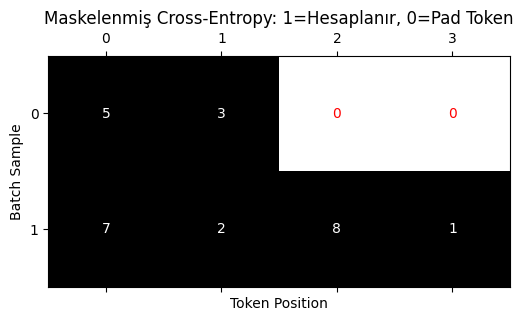

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Örnek batch
# 0 = PAD, diğer sayılar token id
target_ids = np.array([
    [5, 3, 0, 0],   # kısa cümle
    [7, 2, 8, 1]    # uzun cümle
])

# Mask: 1 gerçek token, 0 pad
mask = (target_ids != 0).astype(int)

fig, ax = plt.subplots(figsize=(6,3))
cax = ax.matshow(mask, cmap='Greys')

for (i, j), val in np.ndenumerate(target_ids):
    ax.text(j, i, f"{val}", ha='center', va='center', color='red' if mask[i,j]==0 else 'white')

ax.set_xticks(range(target_ids.shape[1]))
ax.set_yticks(range(target_ids.shape[0]))
ax.set_xlabel("Token Position")
ax.set_ylabel("Batch Sample")
ax.set_title("Maskelenmiş Cross-Entropy: 1=Hesaplanır, 0=Pad Token")
plt.show()


## Açıklama:

* Matrisin beyaz kareleri gerçek tokenler → loss hesaplamaya dahil.

* Kırmızı kareler padding tokenler → loss hesaplamada yok sayılır.

* Böylece model sadece anlamlı tokenler üzerinden öğrenir.

---
# Maskelenmiş Cross-Entropy Loss Adım Adım

* Bu hücrede, maskelenmiş cross-entropy loss'un nasıl çalıştığını görselleştiriyoruz.  

- **Maskeli loss:** Padding tokenler (`PAD`) hesaplamaya dahil edilmez.  
- **Adım adım:** Her batch ve token için loss ayrı ayrı gösterilir, sonra maskeye göre toplam loss hesaplanır.


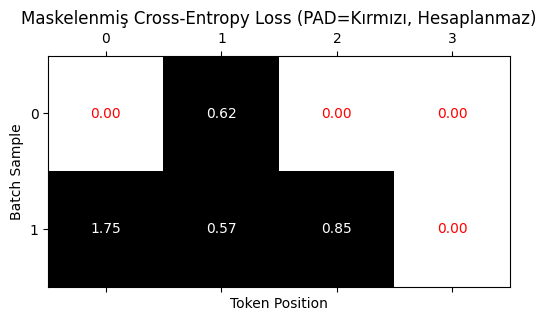

Toplam Maskelenmiş Loss: 0.9489


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Örnek logits (softmax öncesi) ve target
logits = torch.tensor([
    [[2.0, 0.5, 0.1], [0.1, 1.0, 0.2], [0.2, 0.3, 0.5], [0.0, 0.0, 0.0]],  # batch 1
    [[1.5, 0.3, 0.2], [0.0, 1.0, 0.1], [0.2, 0.2, 0.6], [1.0, 0.0, 0.0]]   # batch 2
])
target_ids = torch.tensor([
    [0, 1, 0, 0],  # PAD token = 0
    [2, 1, 2, 0]
])
pad_token_id = 0

# Loss fonksiyonu
loss_fct = nn.CrossEntropyLoss(ignore_index=pad_token_id, reduction='none')

# Flatten (batch*seq_len, vocab_size) ve target
logits_flat = logits.view(-1, logits.size(-1))
target_flat = target_ids.view(-1)

loss_per_token = loss_fct(logits_flat, target_flat).view(target_ids.size())

# Maskeyi görselleştir
mask = (target_ids != pad_token_id).float()

fig, ax = plt.subplots(figsize=(8,3))
cax = ax.matshow(mask, cmap='Greys')

for (i,j), val in np.ndenumerate(loss_per_token.numpy()):
    color = 'white' if mask[i,j]==1 else 'red'
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=color)

ax.set_xticks(range(target_ids.size(1)))
ax.set_yticks(range(target_ids.size(0)))
ax.set_xlabel("Token Position")
ax.set_ylabel("Batch Sample")
ax.set_title("Maskelenmiş Cross-Entropy Loss (PAD=Kırmızı, Hesaplanmaz)")
plt.show()

# Toplam loss
total_loss = (loss_per_token * mask).sum() / mask.sum()
print(f"Toplam Maskelenmiş Loss: {total_loss.item():.4f}")


### Bu hücreyi çalıştırdığında:

* Her token için loss karelerin içinde gösterilir.

* Maskelenmiş tokenler (PAD) kırmızı ve loss hesaplamaya dahil edilmez.

* Toplam loss maskeye göre normalize edilir.

---